In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-datasets-1/cavallo/OIP-mdvOxIWAyReAoEJcMk5z4wHaJ4.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-TPYKs3XId_sMgp_6LLA6JgDMEy.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-jlVRrokx7Vu1axi8OnTX2AHaE2.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-F4QVZ71QagiynDMnFNxJUAHaEK.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-UFtUZnXq0JHZo5R8UuF80wHaFj.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-irWuWeIWd3Hm3BWGd0OEsQHaGO.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-Y-hB14A3coI7TEgrEew0UAHaFj.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-KqeKmYfnRwKd89nLg8_zRAHaHb.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-s40xdXSQY099gt1hLGlzAwHaFP.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-4k_sWoJ4_9-G1f0emDBVtwHaE6.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-W-uUxHx-yovp1DQNtX1qdQHaFk.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-Npxx8kemjjTljUyT9-BQgAHaFi.jpeg
/kaggle/input/animal-datasets-1/cavallo/OIP-jCu7nlv58_Tf7GZFbL4VSwHaLH.jpeg
/kaggle/inpu

In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: True
Using device: Tesla P100-PCIE-16GB


In [3]:
import os
import shutil
import zipfile
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import time 
since=time.time()

In [4]:
working_dir = "/kaggle/working"
 
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
        print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

Deleted: /kaggle/working/__notebook__.ipynb


In [5]:
!pip install -q scikit-learn tqdm

In [6]:
import os

base_path = "/kaggle/input/animal-datasets-1"
print("Classes found:", os.listdir(base_path))

Classes found: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


In [7]:
# Define paths
source_dir = "/kaggle/input/animal-datasets-1"
train_dir = "/kaggle/working/dataset/train"
val_dir = "/kaggle/working/dataset/val"
test_dir = "/kaggle/working/dataset/test"  # New test directory

# Create directories for train, val, and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split dataset into train, val, and test (80/10/10)
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # Split remaining 20% into 10% test, 10% val

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Copy images into the respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("✅ Dataset split complete into train/val/test.")


✅ Dataset split complete into train/val/test.


In [8]:
import numpy as np

temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(train_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# Initialize
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(temp_loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # [B, C, H*W]
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Calculated mean:", mean)
print("Calculated std:", std)

100%|██████████| 328/328 [01:07<00:00,  4.86it/s]


Calculated mean: tensor([0.5177, 0.5003, 0.4128])
Calculated std: tensor([0.2134, 0.2131, 0.2152])


In [9]:
# Mean and std from your dataset
mean = [0.5177, 0.5003, 0.4128]
std  = [0.2134, 0.2131, 0.2152]

# Training transform (with augmentation)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2),  # Adjust brightness, contrast
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation transform (no augmentation)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test transform (no augmentation, same as validation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [10]:
# Load train, validation, and test datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# DataLoader for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders created for train, validation, and test.")

DataLoaders created for train, validation, and test.


In [11]:
# Check the shape of a batch of images
images, labels = next(iter(train_loader))
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


In [12]:
# Load ResNet18 with random initialization (no pretrained weights)
model1 = models.resnet18(weights=None)

# Modify the final fully connected layer to match 10 classes
model1.fc = nn.Linear(model1.fc.in_features, 10)

In [13]:
# Load MobileNetV2 with random initialization (no pretrained weights)
model2 = models.mobilenet_v2(weights=None)

# Modify the classifier to match 10 classes
model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, 10)


In [14]:
# Move models to the available GPU (or CPU if no GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model2 = model2.to(device)

print(f"Models are ready and using device: {device}")


Models are ready and using device: cuda


In [15]:
# Training function for ResNet18
def train_model_resnet(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    total_loss = 0
    for images, labels in tqdm(train_loader, desc="Training ResNet18", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()               # Reset gradients
        outputs = model(images)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backpropagate
        optimizer.step()                    # Update weights

        total_loss += loss.item()           # Accumulate loss

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)    # Predicted class
        correct += (preds == labels).sum().item()  # Count correct predictions
        total += labels.size(0)             # Total number of samples
    
    accuracy = correct / total  # Calculate training accuracy
    return total_loss / len(train_loader), accuracy  # Return both loss and accuracy


In [16]:
# Evaluation function for ResNet18
def evaluate_model_resnet(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # No need to calculate gradients for validation
        for images, labels in tqdm(val_loader, desc="Evaluating ResNet18", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)           # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            total_loss += loss.item()         # Accumulate loss

            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total  # Calculate validation accuracy
    return total_loss / len(val_loader), accuracy  # Return both loss and accuracy


In [17]:
# Hyperparameters
lr = 0.001
epochs = 10

# Loss function and optimizer for ResNet18
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=lr)

train_losses_resnet = []
train_accuracies_resnet = []
val_losses_resnet = []
val_accuracies_resnet = []

best_val_accuracy = 0  # Track the best validation accuracy

# Training loop for ResNet18
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train ResNet18
    train_loss, train_accuracy = train_model_resnet(model1, train_loader, criterion, optimizer1, device)
    val_loss, val_acc = evaluate_model_resnet(model1, val_loader, criterion, device)

    # Store metrics for plotting
    train_losses_resnet.append(train_loss)
    train_accuracies_resnet.append(train_accuracy)
    val_losses_resnet.append(val_loss)
    val_accuracies_resnet.append(val_acc)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc  # Update the best validation accuracy

    print(f"ResNet18 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2%}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2%}")

# Time tracking: Calculate elapsed time
time_elapsed = time.time() - since  # Calculate the time taken for training
print(f"\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Epoch 1/10


ResNet18 - Train Loss: 1.8354, Train Accuracy: 35.47%, Val Loss: 1.6274, Val Accuracy: 41.83%
Best Validation Accuracy: 41.83%
Epoch 2/10


ResNet18 - Train Loss: 1.3652, Train Accuracy: 52.67%, Val Loss: 1.2684, Val Accuracy: 57.10%
Best Validation Accuracy: 57.10%
Epoch 3/10


ResNet18 - Train Loss: 1.1456, Train Accuracy: 60.73%, Val Loss: 1.2223, Val Accuracy: 59.24%
Best Validation Accuracy: 59.24%
Epoch 4/10


ResNet18 - Train Loss: 0.9825, Train Accuracy: 66.42%, Val Loss: 0.9094, Val Accuracy: 69.63%
Best Validation Accuracy: 69.63%
Epoch 5/10


ResNet18 - Train Loss: 0.8666, Train Accuracy: 70.47%, Val Loss: 0.9248, Val Accuracy: 69.29%
Best Validation Accuracy: 69.63%
Epoch 6/10


ResNet18 - Train Loss: 0.7707, Train Accuracy: 73.96%, Val Loss: 0.7619, Val Accuracy: 75.67%
Best Validation Accuracy: 75.67%
Epoch 7/10


ResNet18 - Train Loss: 0.6842, Train Accuracy: 76.76%, Val Loss: 0.6585, Val Accuracy: 77.92%
Best Validation Accuracy: 77.92%
Epoch 8/10


ResNet18 - Train Loss: 0.6204, Train Accuracy: 78.95%, Val Loss: 0.6630, Val Accuracy: 77.08%
Best Validation Accuracy: 77.92%
Epoch 9/10


ResNet18 - Train Loss: 0.5584, Train Accuracy: 81.35%, Val Loss: 0.7252, Val Accuracy: 76.13%
Best Validation Accuracy: 77.92%
Epoch 10/10


ResNet18 - Train Loss: 0.4984, Train Accuracy: 83.43%, Val Loss: 0.5566, Val Accuracy: 81.97%
Best Validation Accuracy: 81.97%

 Training complete in 25m 25s


In [18]:
# Save ResNet18 model
torch.save(model1.state_dict(), "/kaggle/working/resnet18_model.pth")
print("ResNet18 model saved!")

ResNet18 model saved!


In [19]:
# Function to calculate training accuracy for MobileNetV2
def train_model_mobilenet(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    total_loss = 0
    for images, labels in tqdm(train_loader, desc="Training MobileNetV2", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()               # Reset gradients
        outputs = model(images)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backpropagate
        optimizer.step()                    # Update weights

        total_loss += loss.item()           # Accumulate loss

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)    # Predicted class
        correct += (preds == labels).sum().item()  # Count correct predictions
        total += labels.size(0)             # Total number of samples
    
    accuracy = correct / total  # Compute training accuracy
    return total_loss / len(train_loader), accuracy  # Return both loss and accuracy


In [20]:
# Evaluation function for MobileNetV2
def evaluate_model_mobilenet(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # No need to calculate gradients for validation
        for images, labels in tqdm(val_loader, desc="Evaluating MobileNetV2", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)           # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            total_loss += loss.item()         # Accumulate loss

            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total  # Calculate validation accuracy
    return total_loss / len(val_loader), accuracy  # Return both loss and accuracy


In [21]:
# Hyperparameters
lr = 0.001
epochs = 10

# Loss function and optimizer for MobileNetV2
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=lr)

train_losses_mobilenet = []
train_accuracies_mobilenet = []
val_losses_mobilenet = []
val_accuracies_mobilenet = []

best_val_accuracy_mobilenet = 0  # Track the best validation accuracy

# Training loop for MobileNetV2
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train MobileNetV2
    train_loss, train_accuracy = train_model_mobilenet(model2, train_loader, criterion, optimizer2, device)
    val_loss, val_acc = evaluate_model_mobilenet(model2, val_loader, criterion, device)

    # Store metrics for plotting
    train_losses_mobilenet.append(train_loss)
    train_accuracies_mobilenet.append(train_accuracy)
    val_losses_mobilenet.append(val_loss)
    val_accuracies_mobilenet.append(val_acc)

    # Save the best model based on validation accuracy
    if val_acc > best_val_accuracy_mobilenet:
        best_val_accuracy_mobilenet = val_acc  # Update the best validation accuracy
        torch.save(model2.state_dict(), f"/kaggle/working/best_mobilenet_model.pth")

    print(f"MobileNetV2 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2%}")
    print(f"Best Validation Accuracy: {best_val_accuracy_mobilenet:.2%}")
    
# Time tracking: Calculate elapsed time
time_elapsed = time.time() - since  # Calculate the time taken for training
print(f"\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Epoch 1/10


MobileNetV2 - Train Loss: 1.8574, Train Accuracy: 34.42%, Val Loss: 1.7671, Val Accuracy: 39.72%
Best Validation Accuracy: 39.72%
Epoch 2/10


MobileNetV2 - Train Loss: 1.4324, Train Accuracy: 50.27%, Val Loss: 1.2043, Val Accuracy: 58.17%
Best Validation Accuracy: 58.17%
Epoch 3/10


MobileNetV2 - Train Loss: 1.1953, Train Accuracy: 59.09%, Val Loss: 1.0131, Val Accuracy: 65.85%
Best Validation Accuracy: 65.85%
Epoch 4/10


MobileNetV2 - Train Loss: 1.0457, Train Accuracy: 64.32%, Val Loss: 0.9459, Val Accuracy: 67.72%
Best Validation Accuracy: 67.72%
Epoch 5/10


MobileNetV2 - Train Loss: 0.9346, Train Accuracy: 68.15%, Val Loss: 0.9372, Val Accuracy: 68.91%
Best Validation Accuracy: 68.91%
Epoch 6/10


MobileNetV2 - Train Loss: 0.8446, Train Accuracy: 71.90%, Val Loss: 0.9092, Val Accuracy: 70.09%
Best Validation Accuracy: 70.09%
Epoch 7/10


MobileNetV2 - Train Loss: 0.7765, Train Accuracy: 73.92%, Val Loss: 0.7769, Val Accuracy: 73.91%
Best Validation Accuracy: 73.91%
Epoch 8/10


MobileNetV2 - Train Loss: 0.7086, Train Accuracy: 76.44%, Val Loss: 0.7846, Val Accuracy: 73.80%
Best Validation Accuracy: 73.91%
Epoch 9/10


MobileNetV2 - Train Loss: 0.6527, Train Accuracy: 78.09%, Val Loss: 0.6491, Val Accuracy: 79.45%
Best Validation Accuracy: 79.45%
Epoch 10/10


MobileNetV2 - Train Loss: 0.6074, Train Accuracy: 79.28%, Val Loss: 0.6332, Val Accuracy: 79.53%
Best Validation Accuracy: 79.53%

 Training complete in 50m 6s


In [22]:
# Save MobileNetV2 model
torch.save(model2.state_dict(), "/kaggle/working/mobilenetv2_model.pth")
print("MobileNetV2 model saved!")

MobileNetV2 model saved!


In [23]:
# Evaluate on test set for ResNet18
test_loss_resnet, test_acc_resnet = evaluate_model_resnet(model1, test_loader, criterion, device)
print(f"ResNet18 Test Loss: {test_loss_resnet:.4f}, Test Accuracy: {test_acc_resnet:.2%}")

ResNet18 Test Loss: 0.5612, Test Accuracy: 81.85%


In [24]:
# Evaluate on test set for MobileNetV2
test_loss_mobilenet, test_acc_mobilenet = evaluate_model_mobilenet(model2, test_loader, criterion, device)
print(f"MobileNetV2 Test Loss: {test_loss_mobilenet:.4f}, Test Accuracy: {test_acc_mobilenet:.2%}")

MobileNetV2 Test Loss: 0.6498, Test Accuracy: 78.35%


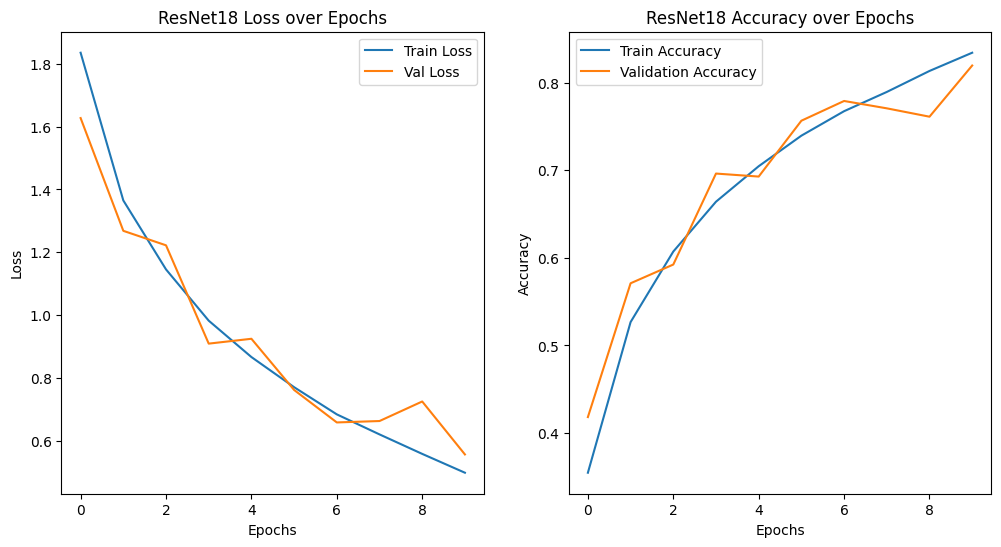

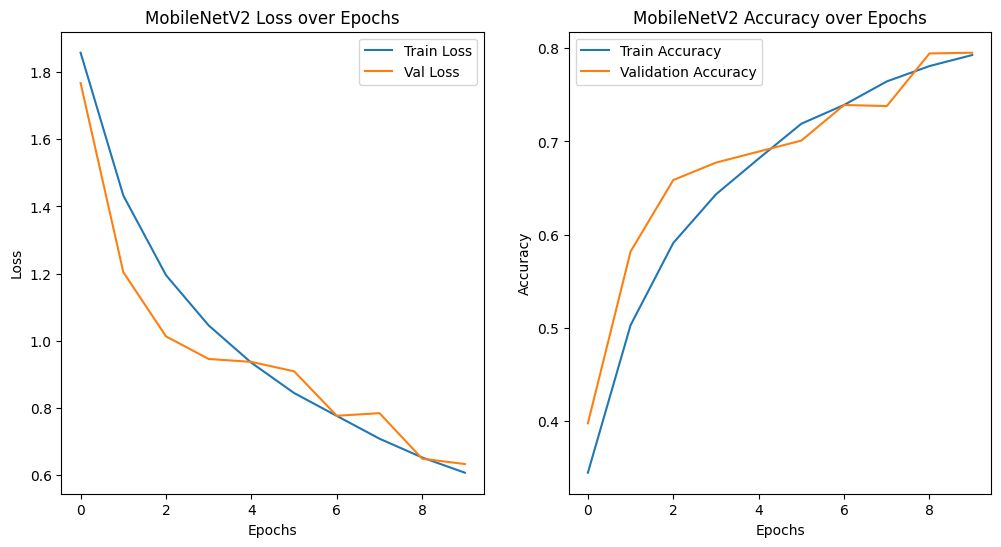

In [25]:
# Plot ResNet18 Loss and Accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet, label="Train Loss")
plt.plot(val_losses_resnet, label="Val Loss")
plt.title('ResNet18 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_resnet, label="Train Accuracy")
plt.plot(val_accuracies_resnet, label="Validation Accuracy")
plt.title('ResNet18 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot MobileNetV2 Loss and Accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_mobilenet, label="Train Loss")
plt.plot(val_losses_mobilenet, label="Val Loss")
plt.title('MobileNetV2 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_mobilenet, label="Train Accuracy")
plt.plot(val_accuracies_mobilenet, label="Validation Accuracy")
plt.title('MobileNetV2 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


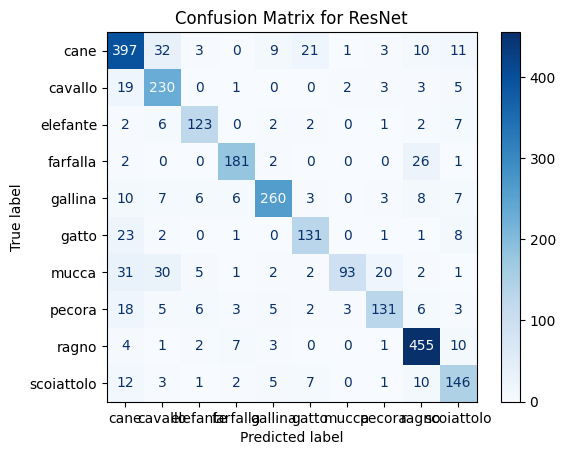

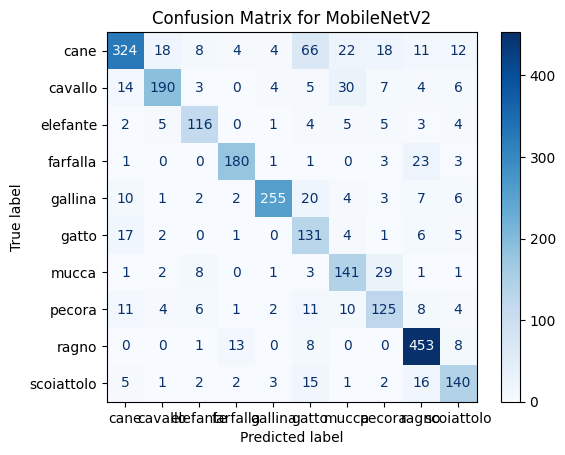

In [26]:
# Extract class names from the dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = train_dataset.classes  # Get class names from the train dataset

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    preds = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Plot confusion matrix for ResNet18
plot_confusion_matrix(model1, test_loader, device, class_names)

# Plot confusion matrix for MobileNetV2
plot_confusion_matrix(model2, test_loader, device, class_names)


In [27]:
from torchvision.models import vgg16, VGG16_Weights

vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)  # 10 classes
)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 237MB/s]


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

print(f"Models are ready and using device: {device}")

Models are ready and using device: cuda


In [29]:
def train_model_vgg(vgg16, train_loader, criterion, optimizer, device):
    vgg16.train()
    correct = 0
    total = 0
    total_loss = 0

    for images, labels in tqdm(train_loader, desc="Training VGG16", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [30]:
def evaluate_model_vgg(vgg16, val_loader, criterion, device):
    vgg16.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating VGG16", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct/total
    return total_loss / len(val_loader), accuracy

In [31]:
# Setup
lr = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=lr)

# Metric tracking
train_losses_vgg = []
train_accuracies_vgg = []
val_losses_vgg = []
val_accuracies_vgg = []
best_val_accuracy = 0

# Epoch loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_accuracy = train_model_vgg(vgg16, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model_vgg(vgg16, val_loader, criterion, device)

    train_losses_vgg.append(train_loss)
    train_accuracies_vgg.append(train_accuracy)
    val_losses_vgg.append(val_loss)
    val_accuracies_vgg.append(val_acc)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc

    print(f"VGG16 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2%}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2%}")

# Time tracking
time_elapsed = time.time() - since
print(f"\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Epoch 1/10


VGG16 - Train Loss: 0.5786, Train Accuracy: 85.24%, Val Loss: 0.2230, Val Accuracy: 94.23%
Best Validation Accuracy: 94.23%
Epoch 2/10


VGG16 - Train Loss: 0.4316, Train Accuracy: 89.24%, Val Loss: 0.2132, Val Accuracy: 95.23%
Best Validation Accuracy: 95.23%
Epoch 3/10


VGG16 - Train Loss: 0.3885, Train Accuracy: 90.63%, Val Loss: 0.2873, Val Accuracy: 93.85%
Best Validation Accuracy: 95.23%
Epoch 4/10


VGG16 - Train Loss: 0.4137, Train Accuracy: 90.75%, Val Loss: 0.2177, Val Accuracy: 95.30%
Best Validation Accuracy: 95.30%
Epoch 5/10


VGG16 - Train Loss: 0.3627, Train Accuracy: 91.62%, Val Loss: 0.3210, Val Accuracy: 94.31%
Best Validation Accuracy: 95.30%
Epoch 6/10


VGG16 - Train Loss: 0.3886, Train Accuracy: 91.36%, Val Loss: 0.2800, Val Accuracy: 95.45%
Best Validation Accuracy: 95.45%
Epoch 7/10


VGG16 - Train Loss: 0.3211, Train Accuracy: 92.63%, Val Loss: 0.2507, Val Accuracy: 95.26%
Best Validation Accuracy: 95.45%
Epoch 8/10


VGG16 - Train Loss: 0.3267, Train Accuracy: 92.47%, Val Loss: 0.2728, Val Accuracy: 95.19%
Best Validation Accuracy: 95.45%
Epoch 9/10


VGG16 - Train Loss: 0.3587, Train Accuracy: 92.38%, Val Loss: 0.3083, Val Accuracy: 95.15%
Best Validation Accuracy: 95.45%
Epoch 10/10


VGG16 - Train Loss: 0.3273, Train Accuracy: 92.85%, Val Loss: 0.3382, Val Accuracy: 95.53%
Best Validation Accuracy: 95.53%

 Training complete in 77m 38s


In [32]:
torch.save(vgg16.state_dict(), "/kaggle/working/vgg16_model.pth")
print("VGG16 model saved!")

VGG16 model saved!


In [33]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
efficientnet = efficientnet_b0(weights=weights)

for param in efficientnet.features.parameters():
    param.requires_grad = False

in_features = efficientnet.classifier[1].in_features  # Typically 1280
efficientnet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, 10)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 189MB/s]


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

print(f"Models are ready and using device: {device}")

Models are ready and using device: cuda


In [35]:
def train_model_efficientnet(efficientnet, train_loader, criterion, optimizer, device):
    efficientnet.train()
    correct = 0
    total = 0
    total_loss = 0

    for images, labels in tqdm(train_loader, desc="Training EfficientNet_B0", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [36]:
def evaluate_model_efficientnet(efficientnet, val_loader, criterion, device):
    efficientnet.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating EfficientNet_B0", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy


In [37]:
# Setup
lr = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer_eff = torch.optim.Adam(efficientnet.classifier.parameters(), lr=lr)

# Metric tracking
train_losses_eff = []
train_accuracies_eff = []
val_losses_eff = []
val_accuracies_eff = []
best_val_accuracy_eff = 0

# Epoch loop
since = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_accuracy = train_model_efficientnet(efficientnet, train_loader, criterion, optimizer_eff, device)
    val_loss, val_acc = evaluate_model_efficientnet(efficientnet, val_loader, criterion, device)

    train_losses_eff.append(train_loss)
    train_accuracies_eff.append(train_accuracy)
    val_losses_eff.append(val_loss)
    val_accuracies_eff.append(val_acc)

    if val_acc > best_val_accuracy_eff:
        best_val_accuracy_eff = val_acc

    print(f"EfficientNet_B0 - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2%}")
    print(f"Best Validation Accuracy: {best_val_accuracy_eff:.2%}")

# Time tracking
time_elapsed = time.time() - since
print(f"\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Epoch 1/10


EfficientNet_B0 - Train Loss: 0.4827, Train Accuracy: 87.90%, Val Loss: 0.2266, Val Accuracy: 94.50%
Best Validation Accuracy: 94.50%
Epoch 2/10


EfficientNet_B0 - Train Loss: 0.2713, Train Accuracy: 91.70%, Val Loss: 0.1819, Val Accuracy: 94.84%
Best Validation Accuracy: 94.84%
Epoch 3/10


EfficientNet_B0 - Train Loss: 0.2473, Train Accuracy: 92.28%, Val Loss: 0.1603, Val Accuracy: 95.61%
Best Validation Accuracy: 95.61%
Epoch 4/10


EfficientNet_B0 - Train Loss: 0.2361, Train Accuracy: 92.70%, Val Loss: 0.1534, Val Accuracy: 95.49%
Best Validation Accuracy: 95.61%
Epoch 5/10


EfficientNet_B0 - Train Loss: 0.2318, Train Accuracy: 92.65%, Val Loss: 0.1545, Val Accuracy: 95.38%
Best Validation Accuracy: 95.61%
Epoch 6/10


EfficientNet_B0 - Train Loss: 0.2202, Train Accuracy: 92.92%, Val Loss: 0.1536, Val Accuracy: 95.42%
Best Validation Accuracy: 95.61%
Epoch 7/10


EfficientNet_B0 - Train Loss: 0.2203, Train Accuracy: 92.98%, Val Loss: 0.1618, Val Accuracy: 95.38%
Best Validation Accuracy: 95.61%
Epoch 8/10


EfficientNet_B0 - Train Loss: 0.2204, Train Accuracy: 93.02%, Val Loss: 0.1429, Val Accuracy: 95.49%
Best Validation Accuracy: 95.61%
Epoch 9/10


EfficientNet_B0 - Train Loss: 0.2179, Train Accuracy: 93.01%, Val Loss: 0.1510, Val Accuracy: 95.53%
Best Validation Accuracy: 95.61%
Epoch 10/10


EfficientNet_B0 - Train Loss: 0.2072, Train Accuracy: 93.42%, Val Loss: 0.1511, Val Accuracy: 95.42%
Best Validation Accuracy: 95.61%

 Training complete in 18m 53s


In [38]:
torch.save(efficientnet.state_dict(), "/kaggle/working/efficientnet_b0_model.pth")
print("EfficientNet_B0 model saved!")

EfficientNet_B0 model saved!


In [39]:
test_loss_vgg, test_acc_vgg = evaluate_model_vgg(vgg16, test_loader, criterion, device)
print(f"VGG16 Test Loss: {test_loss_vgg:.4f}, Test Accuracy: {test_acc_vgg:.2%}")

VGG16 Test Loss: 0.3139, Test Accuracy: 95.20%


In [40]:
test_loss_eff, test_acc_eff = evaluate_model_efficientnet(efficientnet, test_loader, criterion, device)
print(f"EfficientNet_B0 Test Loss: {test_loss_eff:.4f}, Test Accuracy: {test_acc_eff:.2%}")

EfficientNet_B0 Test Loss: 0.1596, Test Accuracy: 95.08%


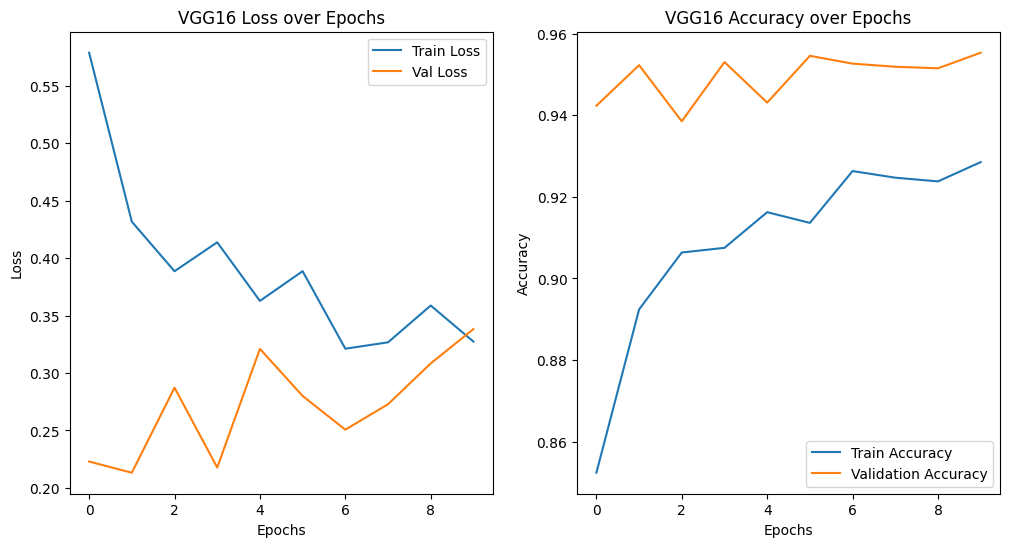

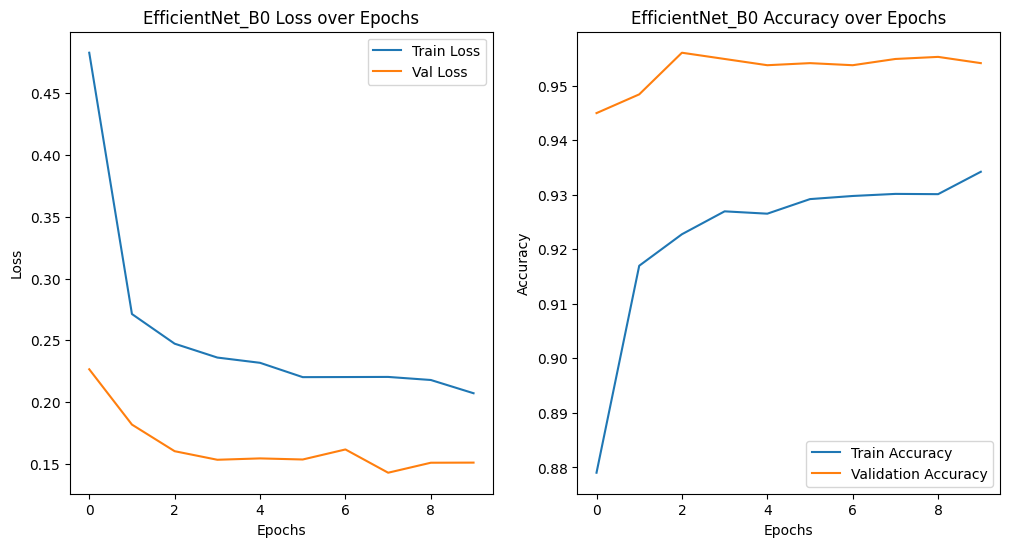

In [41]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_vgg, label="Train Loss")
plt.plot(val_losses_vgg, label="Val Loss")
plt.title('VGG16 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_vgg, label="Train Accuracy")
plt.plot(val_accuracies_vgg, label="Validation Accuracy")
plt.title('VGG16 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_eff, label="Train Loss")
plt.plot(val_losses_eff, label="Val Loss")
plt.title('EfficientNet_B0 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_eff, label="Train Accuracy")
plt.plot(val_accuracies_eff, label="Validation Accuracy")
plt.title('EfficientNet_B0 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


<Figure size 1000x800 with 0 Axes>

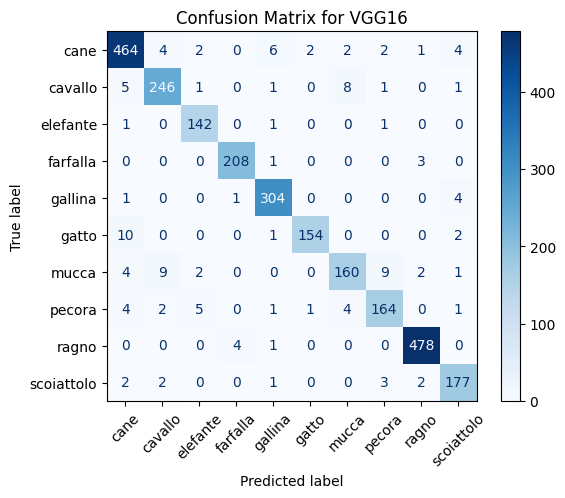

<Figure size 1000x800 with 0 Axes>

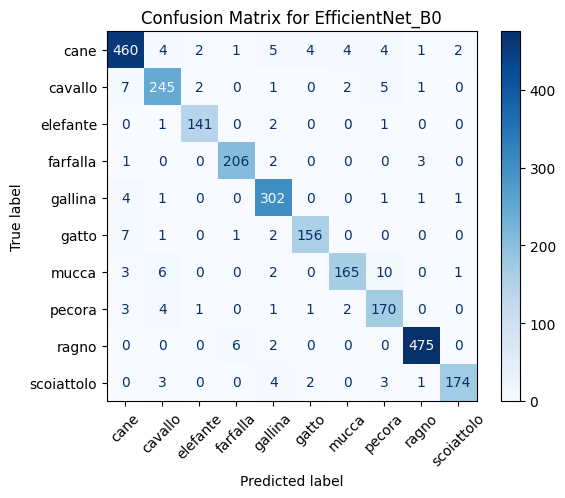

In [42]:
# Automatically extract class labels from the dataset
class_names = train_dataset.classes  # ['dog', 'cat', ..., 'elephant']

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader, device, class_names, model_name="Model"):
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Compute and plot confusion matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# For VGG16
plot_confusion_matrix(vgg16, test_loader, device, class_names, model_name="VGG16")

# For EfficientNet_B0
plot_confusion_matrix(efficientnet, test_loader, device, class_names, model_name="EfficientNet_B0")

In [43]:
import pandas as pd
from IPython.display import display

# Create a comparison table
model_results = {
    "Model": ["ResNet18", "MobileNetV2", "VGG16", "EfficientNet_B0"],
    "Type": ["CNN (Scratch)", "CNN (Scratch)", "Transfer Learning", "Transfer Learning"],
    "Best Val Accuracy": [f"{max(val_accuracies_resnet):.2%}",
                          f"{max(val_accuracies_mobilenet):.2%}",
                          f"{max(val_accuracies_vgg):.2%}",
                          f"{max(val_accuracies_eff):.2%}"],
    "Best Train Accuracy": [f"{max(train_accuracies_resnet):.2%}",
                            f"{max(train_accuracies_mobilenet):.2%}",
                            f"{max(train_accuracies_vgg):.2%}",
                            f"{max(train_accuracies_eff):.2%}"],
    "Test Accuracy": [f"{test_acc_resnet:.2%}",
                      f"{test_acc_mobilenet:.2%}",
                      f"{test_acc_vgg:.2%}",
                      f"{test_acc_eff:.2%}"],
    "Training Time": ["26m 37s", "52m 33s", "81m 51s", "20m 31s"],
    "Notes": ["Stable baseline", "Lightweight, fast", "Deep but stable", "Efficient, highest performance"]
}

# Convert to DataFrame and display
df_results = pd.DataFrame(model_results)
display(df_results)

,Model,Type,Best Val Accuracy,Best Train Accuracy,Test Accuracy,Training Time,Notes
0,ResNet18,CNN (Scratch),81.97%,83.43%,81.85%,26m 37s,Stable baseline
1,MobileNetV2,CNN (Scratch),79.53%,79.28%,78.35%,52m 33s,"Lightweight, fast"
2,VGG16,Transfer Learning,95.53%,92.85%,95.20%,81m 51s,Deep but stable
3,EfficientNet_B0,Transfer Learning,95.61%,93.42%,95.08%,20m 31s,"Efficient, highest performance"
